[Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/data)

# 引入資料

In [1]:
import pandas as pd
import numpy as np
import copy, time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

In [2]:
data_path = 'data/'
df_train = pd.read_csv(data_path + 'train.csv')
df_test = pd.read_csv(data_path + 'test.csv')

train_Y = df_train['Survived']
ids = df_test['PassengerId']
df_train = df_train.drop(['PassengerId', 'Survived'], axis=1)
df_test = df_test.drop(['PassengerId'], axis=1)
df = pd.concat([df_train, df_test])
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
a = (df.isnull().sum() / len(df)) * 100
a

Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         20.091673
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.076394
Cabin       77.463713
Embarked     0.152788
dtype: float64

In [4]:
a[a==0].index

Index(['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket'], dtype='object')

# 補缺值

In [5]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(df)

,Missing Ratio
Cabin,77.463713
Age,20.091673
Embarked,0.152788
Fare,0.076394


首先對上列4個columns的缺失值做處理

In [6]:
#Cabin依照第一碼分類，再取One Hot
#Cabin中，null都換成X
df["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df['Cabin']])
df = pd.get_dummies(df, columns = ["Cabin"], prefix="Cabin")

In [7]:
# Age 補眾數
df["Age"] = df["Age"].fillna(df['Age'].median())

In [8]:
# Embarked： null補最多的登陸港口 ，再做One Hot
a = df['Embarked'].value_counts()
b = a[a==a.max()].index
c = b[0]
df["Embarked"] = df["Embarked"].fillna(c)
df = pd.get_dummies(df, columns = ["Embarked"], prefix="Em")

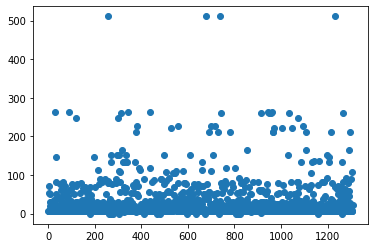

In [9]:
# Fare : null先補眾數，再用 log 去偏態, 0 則直接取 0
df["Fare"] = df["Fare"].fillna(df["Fare"].median())

#先用散佈圖 看Fare的分布
import matplotlib.pyplot as plt

x_list = []
for i in range(0,df["Fare"].values.shape[0]):
    x_list.append(i)
x = np.array(x_list)
y = df["Fare"].values
df["Fare"].values.shape[0]
plt.scatter(x,y-1)
plt.show()

In [10]:
df["Fare"].describe()

count    1309.000000
mean       33.281086
std        51.741500
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [11]:
df["Fare"].median()

14.4542

In [12]:
df["Fare"].values.max()

512.3292

# 特徵工程

In [13]:
# Sex : 直接轉男 0 女 1
df["Sex"] = df["Sex"].map({"male": 0, "female":1})

In [14]:
# Title 的 特徵工程 : 將各種頭銜按照類型分類, 最後取 One Hot
df_title = [i.split(",")[1].split(".")[0].strip() for i in df["Name"]]

In [15]:
df_title

['Mr',
 'Mrs',
 'Miss',
 'Mrs',
 'Mr',
 'Mr',
 'Mr',
 'Master',
 'Mrs',
 'Mrs',
 'Miss',
 'Miss',
 'Mr',
 'Mr',
 'Miss',
 'Mrs',
 'Master',
 'Mr',
 'Mrs',
 'Mrs',
 'Mr',
 'Mr',
 'Miss',
 'Mr',
 'Miss',
 'Mrs',
 'Mr',
 'Mr',
 'Miss',
 'Mr',
 'Don',
 'Mrs',
 'Miss',
 'Mr',
 'Mr',
 'Mr',
 'Mr',
 'Mr',
 'Miss',
 'Miss',
 'Mrs',
 'Mrs',
 'Mr',
 'Miss',
 'Miss',
 'Mr',
 'Mr',
 'Miss',
 'Mr',
 'Mrs',
 'Master',
 'Mr',
 'Mrs',
 'Mrs',
 'Mr',
 'Mr',
 'Miss',
 'Mr',
 'Miss',
 'Master',
 'Mr',
 'Miss',
 'Mr',
 'Master',
 'Mr',
 'Master',
 'Mrs',
 'Mr',
 'Miss',
 'Mr',
 'Mr',
 'Miss',
 'Mr',
 'Mr',
 'Mr',
 'Mr',
 'Mr',
 'Mr',
 'Master',
 'Miss',
 'Mr',
 'Mr',
 'Miss',
 'Mr',
 'Miss',
 'Mrs',
 'Mr',
 'Mr',
 'Miss',
 'Mr',
 'Mr',
 'Mr',
 'Mr',
 'Mr',
 'Mr',
 'Mr',
 'Mr',
 'Mr',
 'Mrs',
 'Mr',
 'Miss',
 'Mr',
 'Mr',
 'Mr',
 'Mr',
 'Mr',
 'Miss',
 'Mr',
 'Mr',
 'Miss',
 'Mr',
 'Miss',
 'Mr',
 'Miss',
 'Miss',
 'Mr',
 'Mr',
 'Mr',
 'Mr',
 'Miss',
 'Mr',
 'Mr',
 'Mr',
 'Miss',
 'Mr',
 'Master',
 'Mr',
 

In [16]:
df["Title"] = pd.Series(df_title)
df["Title"] = df["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df["Title"] = df["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
df["Title"] = df["Title"].astype(int)
df = pd.get_dummies(df, columns = ["Title"])

# 捨棄 Name 欄位
df.drop(labels = ["Name"], axis = 1, inplace = True)

In [17]:
# 新建:家庭大小 (Fsize)特徵, 並依照大小分別建獨立欄位
df["Fsize"] = df["SibSp"] + df["Parch"] + 1
df['Single'] = df['Fsize'].map(lambda s: 1 if s == 1 else 0)
df['SmallF'] = df['Fsize'].map(lambda s: 1 if  s == 2  else 0)
df['MedF'] = df['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df['LargeF'] = df['Fsize'].map(lambda s: 1 if s >= 5 else 0)

In [18]:
# Ticket : 如果不只是數字-取第一個空白之前的字串(去除'.'與'/'), 如果只是數字-設為'X', 最後再取 One Hot
Ticket = []
for i in list(df.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append("X")        
df["Ticket"] = Ticket
df = pd.get_dummies(df, columns = ["Ticket"], prefix="T")

In [19]:
#Pclass 做 One Hot
df["Pclass"] = df["Pclass"].astype("category")
df = pd.get_dummies(df, columns = ["Pclass"], prefix="Pc")

In [20]:
na_check(df)
df.head()

,Missing Ratio


,Sex,Age,SibSp,Parch,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0,22.0,1,0,7.2500,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,38.0,1,0,71.2833,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1,35.0,1,0,53.1000,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
4,0,35.0,0,0,8.0500,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [21]:
# 將資料最大最小化
df = MinMaxScaler().fit_transform(df)

# 切分資料，開始建立、訓練模型

In [22]:
# 將前述轉換完畢資料 df , 重新切成 train_X, test_X
train_num = train_Y.shape[0]
train_X = df[:train_num]
test_X = df[train_num:]

In [23]:
x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, test_size = 0.3, random_state=42)

In [24]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((623, 66), (268, 66), (623,), (268,))

    使用 
    LogisticRegression,
    KNN,
    SVM,
    NAIBE BAYES,
    DECISON TREE,
    RandomForestClassifier,
    GradientBoostingClassifier(sklearn.GradientBoostingClassifier和XGBoost基本上一樣，但XGboost比較快),
    Stacking

## 邏輯斯迴歸LogisticRegression

In [25]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(tol=0.001, penalty='l2', fit_intercept=True, C=1.0)
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
print('LogisticRegression : ', accuracy_score(y_test, lr_pred))

LogisticRegression :  0.832089552238806


## KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier #KNN
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)
knn_predict = knn_model.predict(x_test)
print('KNeighborsClassifier：', accuracy_score(y_test, knn_predict))

KNeighborsClassifier： 0.8246268656716418


## SVM

In [27]:
from sklearn.svm import SVC
svc_model = SVC(gamma = 'auto')
svc_model.fit(x_train,y_train.values.ravel())
svc_predicted = svc_model.predict(x_test)
print('SVM',accuracy_score(y_test, svc_predicted))

SVM 0.8171641791044776


## NAIBE BAYES

In [28]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
print('Naive Bayes+cross_val_score', cross_val_score(model, x_train, y_train.values.ravel(), cv=10).mean())

Naive Bayes+cross_val_score 0.4174347158218126


## DECISON TREE

In [29]:
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(n_estimators = 100, max_depth=4, random_state = 99)
rfc_model.fit(x_train, y_train.values.ravel())
predicted = rfc_model.predict(x_test)
print('Random Forest', accuracy_score(y_test, predicted))

Random Forest 0.8171641791044776


## RandomForestClassifier

In [30]:
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier()
rfc_model.fit(x_train, y_train)
rfc_predict = rfc_model.predict(x_test)
print('RandomForestClassifier：', accuracy_score(y_test, rfc_predict))

RandomForestClassifier： 0.8022388059701493


## GradientBoostingClassifier

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
gdbt_model = GradientBoostingClassifier()
gdbt_model.fit(x_train, y_train)
gdbt_predict = gdbt_model.predict(x_test)
print('GradientBoostingClassifier：', accuracy_score(y_test, gdbt_predict))

GradientBoostingClassifier： 0.8059701492537313


LogisticRegression的accuracy分數最高。

## Stacking

In [32]:
from mlxtend.classifier import StackingClassifier
meta_estimator = GradientBoostingClassifier(tol=100, subsample=0.70, n_estimators=50, 
                                            max_features='sqrt', max_depth=4, learning_rate=0.3)
stacking = StackingClassifier(classifiers=[lr, knn_model, rfc_model, gdbt_model], meta_classifier=meta_estimator, use_probas=True, average_probas=False)

In [33]:
#訓練模型
stacking.fit(x_train, y_train)
stacking_pred = stacking.predict(x_test)
print("Stacking(lr, knn, rfc, gdbt)：",accuracy_score(y_test, stacking_pred))

Stacking(lr, knn, rfc, gdbt)： 0.7835820895522388


將test集的x拿來預測(test_X)，並輸出成csv上傳kaggle

In [34]:
stacking_pred = stacking.predict(test_X)
sub = pd.DataFrame({'PassengerId': ids, 'Survived': stacking_pred})
sub.to_csv('titanic_stacking.csv', index=False)